# Self-Driving Car Engineer Nanodegree
## Deep Learning Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [31]:
# Load pickled data
import pickle

training_file = 'traffic_signs_data/train.p'
validation_file= 'traffic_signs_data/valid.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 3)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [32]:
import numpy as np

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of valid examples=", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of valid examples= 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

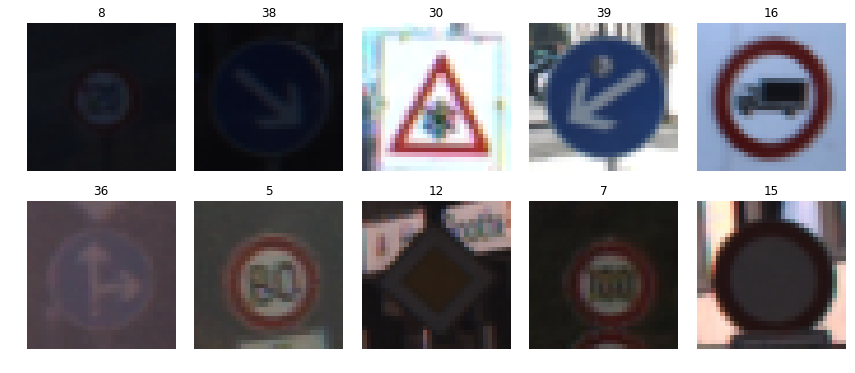

In [33]:
### Data exploration visualization goes here.
import matplotlib.pyplot as plt
import random
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

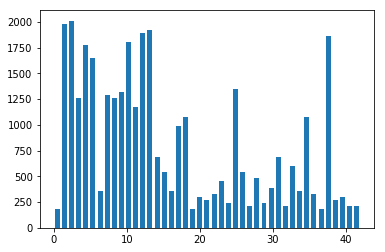

In [34]:
# histogram of label n_classes
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()



## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set


The default value of normalized image data was suggested to be (pixel - 128)/ 128,
but here the data was normalized by (pixel)/ 255.

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


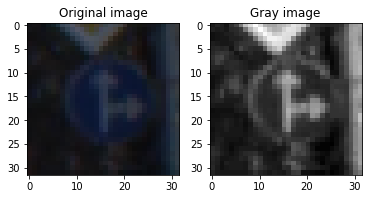

In [35]:
#convert to gray scale
import numpy as np
import cv2

def reshape_raw_images(imgs):
    #Given 4D images (number, heigh, weight, channel), this
    #function grayscales and returns (number, height, weight, 1) images
    
    def gray(src):
        dst = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        return dst.reshape(32,32,1)
    norms = [gray(img) for img in imgs]
    return np.array(norms)


features_train = reshape_raw_images(X_train)
labels_train   = y_train

features_valid = reshape_raw_images(X_valid)
labels_valid   = y_valid

features_test  = reshape_raw_images(X_test)
labels_test    = y_test


_, vframes = plt.subplots(nrows=1, ncols=2)
vframes[0].set_title("Original image")
vframes[1].set_title("Gray image")

vframes[0].imshow(X_train[1000])
vframes[1].imshow(features_train[1000].squeeze(), cmap='gray')

print('RGB shape:', X_train.shape)
print('Grayscale shape:', features_train.shape)


## Normalize the train datasets to (-1,1)
features_train = (features_train)/255

#Normalize the validation and test datasets to (-1,1)
features_valid = (features_valid)/255

##Normalize test datasets to (-1,1)
features_test=(features_test)/255


An example of normalized image

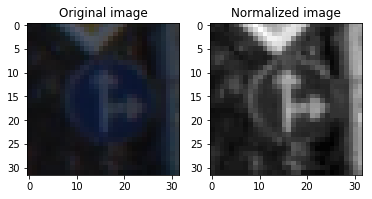

In [36]:
#Show normalized image
_, vframes = plt.subplots(nrows=1, ncols=2)


vframes[0].set_title("Original image")
vframes[1].set_title("Normalized image")
        
vframes[0].imshow(X_train[1000])
vframes[1].imshow(features_train[1000].squeeze(), cmap='gray')

## Model Architecture

Architecture:
 I adapted LeNet architecture: Two convolutional layers followed by one flatten layer and three fully connected linear layers.
 
     convolution 1: 32x32x1  -> 28x28x12 -> relu -> 14x14x12 (pooling)
     convolution 2: 14x14x12 -> 10x10x25 -> relu -> 5x5x25   (pooling)
        flatten: 5x5x25   -> 625  
        drop out: 625      -> 625
        linear: 625      -> 300
        linear: 300      -> 100
        linear: 100      -> 43

In [37]:
import tensorflow as tf

mu, sigma = 0, 0.1

def conv(input, in_len, in_depth, out_len, out_depth):
    filter_len = in_len - out_len + 1
    
    # I am not going to use stride to reduce the dimention, 
    # I am going to use pooling instead.
    strides = [1,1,1,1]

    W = tf.Variable(tf.truncated_normal(shape=(filter_len, filter_len, in_depth, out_depth), \
                                        mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_depth))
    model = tf.nn.conv2d(input, W, strides=strides, padding='VALID') + b
    return model

def linear(input, in_size, out_size):
    W = tf.Variable(tf.truncated_normal(shape=(in_size, out_size), \
                                        mean=mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_size))
    model = tf.matmul(input, W) + b
    return model
    
def classifier(input, keep_prob):
    ## Layer1
    # convolution layer: 32x32x1 -> 28x28x12
    conv1 = conv(input, 32, 1, 28, 12)
    conv1 = tf.nn.relu(conv1)
    # pooling: 28x28x12 -> 14x14x12
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    ## Layer2
    # convolution layer 14x14x12 -> 10x10x25
    conv2 = conv(conv1, 14, 12, 10, 25)
    conv2 = tf.nn.relu(conv2)
    # pooling: 10x10x25 -> 5x5x25
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    ## Layer3
    # -> 625
    flat = tf.contrib.layers.flatten(conv2)
    dropped = tf.nn.dropout(flat, keep_prob)
    layer3 = linear(dropped, 625, 300)
    layer3 = tf.nn.relu(layer3)
    
    ## Layer4
    layer4 = linear(layer3, 300, 100)
    layer4 = tf.nn.relu(layer4)
    
    ## Layer 5
    layer5 = linear(layer4, 100, n_classes)
    return layer5


### Train, Validate and Test the Model

In my train model, the Epoch is set to be 12, batch size is 64, training rate is 0.001, ans drop-out is 0.5. The optimilzer here is using AdamOptimizer.

In [39]:
#Train, Validate and Test the Model
### Define the model and its input

from sklearn.utils import shuffle

# Define training parameters
epoch = 12
batch_size = 64
rate = 0.001


feature_shape = features_train.shape[1:]
x = tf.placeholder(tf.float32, shape=(None,)+feature_shape)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
# drop out layer parameter. This parameter should be 1.0 when evaluate and test
# the model, less than 1.0 when training
keep_prob = tf.placeholder(tf.float32)

logits = classifier(x, keep_prob)

# A function for evaluating the accuracy of a model
prediction_step = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuary_step = tf.reduce_mean(tf.cast(prediction_step, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuary_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [40]:
import time

saver = tf.train.Saver()
model_file = './model'

### training
### Training the model use adam optimizer to minimize the cross entropy (loss)
from sklearn.model_selection import train_test_split

# Training pipepline
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
train_step  = tf.train.AdamOptimizer(learning_rate=rate).minimize(loss)

# Starts training
def train(X_data, y_data):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("starting ...")
        for i in range(epoch):
            X_train, X_tst, y_train, y_tst = train_test_split(X_data, y_data, test_size=0.2, random_state = 42)
            begin_time = time.time()
            for offset in range(0, len(X_train), batch_size):
                end = offset + batch_size
                features, labels = X_train[offset:end], y_train[offset:end]
                sess.run(train_step, feed_dict={x : features, y : labels, keep_prob: 0.5})
            validation = evaluate(X_tst, y_tst)
            print("[{3:.1f}s] epoch {0}/{1}: validation = {2:.3f}".format(i+1, epoch, validation, time.time()-begin_time))

        saver.save(sess, model_file);
        print("model saved into {}".format(model_file))



### Train the model

In [41]:
# train
train(features_train, labels_train)

starting ...
[20.2s] epoch 1/12: validation = 0.854
[21.3s] epoch 2/12: validation = 0.933
[20.4s] epoch 3/12: validation = 0.954
[20.6s] epoch 4/12: validation = 0.966
[21.1s] epoch 5/12: validation = 0.976
[20.5s] epoch 6/12: validation = 0.980
[22.7s] epoch 7/12: validation = 0.986
[22.5s] epoch 8/12: validation = 0.983
[21.0s] epoch 9/12: validation = 0.987
[21.4s] epoch 10/12: validation = 0.987
[21.7s] epoch 11/12: validation = 0.990
[21.8s] epoch 12/12: validation = 0.990
model saved into ./model



### Evaluate the validate set

In [42]:
# evaluate the validate set
with tf.Session() as sess:
    saver.restore(sess, model_file)
    accurency = evaluate(features_valid, labels_valid)
    print("accuracy in validation set: {:.3f}".format(accurency))

INFO:tensorflow:Restoring parameters from ./model
accuracy in validation set: 0.965



### Test the result

In [43]:
# test
with tf.Session() as sess:
    saver.restore(sess, model_file)
    acc = evaluate(features_test, labels_test)
    print("accuracy in test set: ", acc)

INFO:tensorflow:Restoring parameters from ./model
accuracy in test set:  0.9474267616691046



## Step 3: Test a Model on New Images


### Load and Output the Images

In [44]:
from PIL import Image
import os
import glob


# maps from class index into human readable text
import csv

signname = {}
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for r in reader:
        if r[0].isdigit():
            signname[int(r[0])] = r[1]
            
NCLASS = len(signname)

def read_image(file):
    x = Image.open(file).convert("RGB")
    x = x.resize((32,32))
    return np.array(x)

folder = "testdata/"
files = [f for f in os.listdir(folder) if f.endswith("png") or f.endswith("jpg")]
paths = [os.path.join(folder, f) for f in files]
my_labels = [int(f.split('.')[0]) for f in files]
#print("my_labels=",my_labels)
my_images = np.array([read_image(f) for f in paths])


###  Predict the Sign Type for Each Image

In [45]:
# preprocess images
my_features = reshape_raw_images(my_images)
my_features = my_features/255

# Here is a function to predict images and output human readable sign names
def predict(features, human_readable=False):
    with tf.Session() as sess:
        saver.restore(sess, model_file)
        results = sess.run(tf.argmax(logits, 1), {x : features, keep_prob:1.0})
        if human_readable:
            results = [signname[n] for n in results]
        return results



predict(my_features, True)

INFO:tensorflow:Restoring parameters from ./model


['Right-of-way at the next intersection',
 'Keep right',
 'General caution',
 'Speed limit (30km/h)',
 'Priority road',
 'Speed limit (60km/h)',
 'Road work',
 'Turn left ahead']

### Analyze Performance

In [46]:
with tf.Session() as sess:    
    saver.restore(sess, model_file)
    acc = evaluate(my_features, my_labels)
    print("accuracy is {:.3f}".format(acc))

INFO:tensorflow:Restoring parameters from ./model
accuracy is 1.000




### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./model


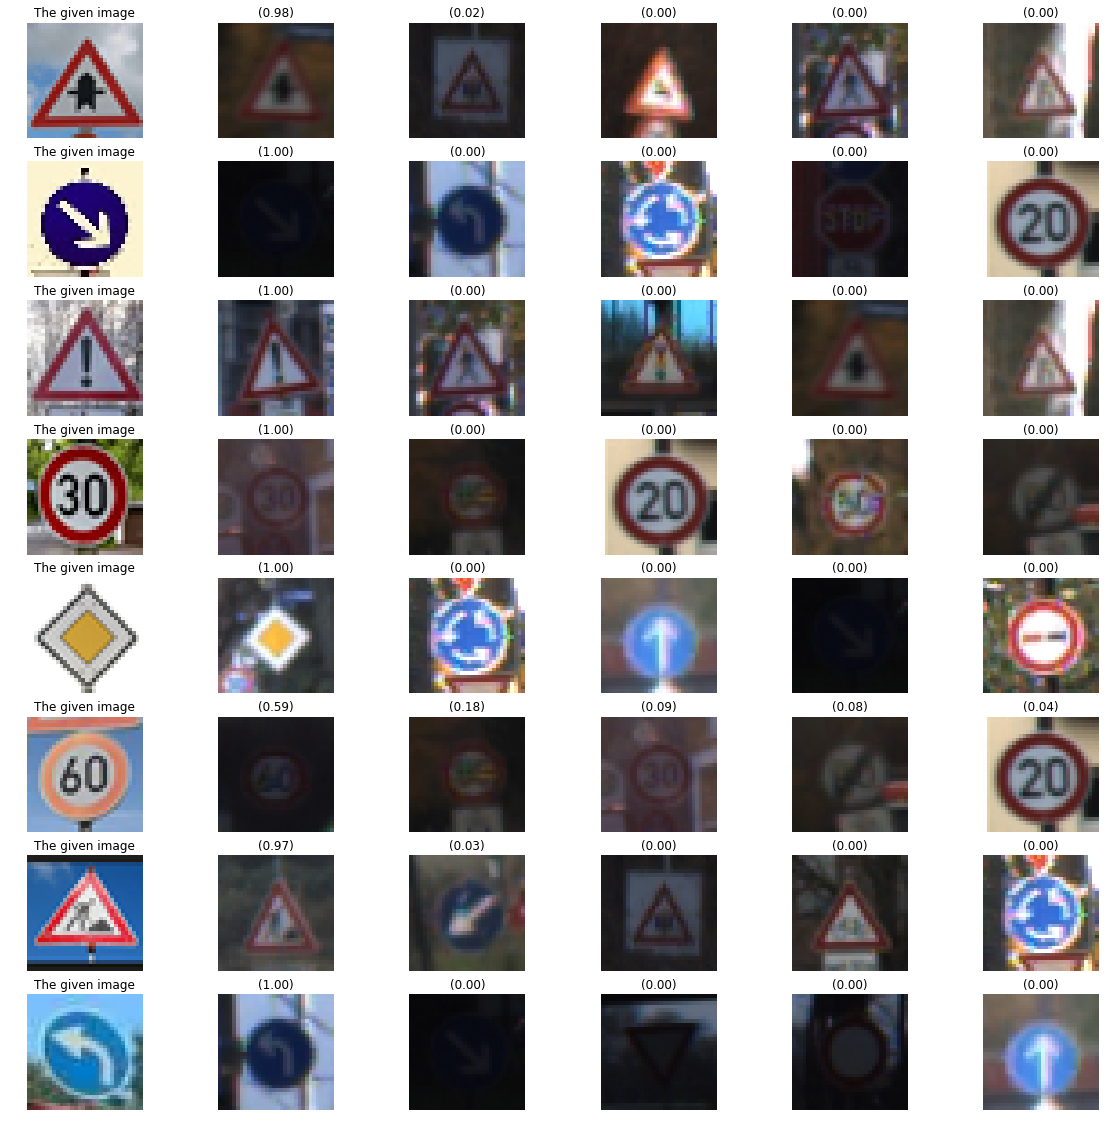

In [47]:
def prediction_in_detail(features):
    with tf.Session() as sess:
        saver.restore(sess, model_file)
        pred = tf.nn.softmax(logits)
        results = sess.run(tf.nn.top_k(pred, k=5), {x : features, keep_prob:1.0})
        return results

pd = prediction_in_detail(my_features)
#print(pd)

def samples_stat(features, labels):
    h = [0 for i in range(NCLASS)]
    samples = {}
    for idx, l in enumerate(labels):
        h[l] += 1
        if l not in samples:
            samples[l] = features[idx]
    return h, samples
_, training_samples = samples_stat(X_train, y_train)
training_readable_labels = signname




def explore_topkv(features, topkv):
    "Functions to explore the given data set"
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    ncols = len(topkv.values[0])+1
    nrows = len(topkv.values)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for r, img in enumerate(features):
        # no axis
        for c in range(ncols):
            axes[r][c].axis('off')
        # show the given image
        cur = axes[r][0]
        cur.imshow(img)
        cur.set_title("The given image")
        # show the top five softmax prob
        for c,prob in enumerate(topkv.values[r]):
            cur = axes[r][c+1]
            class_idx = topkv.indices[r][c]
            sample = training_samples[class_idx]
            #sample_text = training_readable_labels[class_idx]
            cur.imshow(sample)
            #cur.set_title("{} ({:.2f})".format(sample_text, prob))
            cur.set_title("({:.2f})".format(prob))
   # plt.rcParams['figure.figsize'] = figsize_default


explore_topkv(my_images, pd)